# Asymmetric Experience Reply (ER_AML - ER_ACE)

## Paper analysis

Import of libraries.

In [1]:
import json

from src.utils.plot import plot_over_experiences, plot_forgetting, plot_accuracy_tables, plot_general_results, plot_bn_over_epochs

### 1. Project objectives

ER_ACE and ER_AML are two techniques used in deep continual learning field. Both of them are able to compute the loss function in an asymmetric way so dividing it in a sum of two losses:
- `loss_in`: Loss computed on new minibatch of the current experience
- `loss_buffer`: Loss computed on a replay memory called buffer

Both the techniques uses replay memory that is balanced over classes and compute the `loss_buffer` using cross entropy loss. The difference between the two methods are in the `loss_in`:

- `ER_AML`: it is able to sample positive and negative examples from memory related to each example in the current minibatch and compute the exponential of cosine similarity between each example of minibatch and related positive and negative examples. In practice, we want to minimize the distance between new examples and stored examples of the same class. The similarity is computed between features of inputs; in fact the model should provide hidden features used to compare examples and compute their similarity.
- `ER_ACE`: it is able to approximate the ER_AML behavior using cross entropy. It computes the cross entropy loss of new minibatch examples with respect to related targets but masking to zero classes already seen.

Resources used during implementation are:
- [avalanche](https://github.com/ContinualAI/avalanche): For strategy construction and ResNet18 model
- [continual-learning-baselines](https://github.com/ContinualAI/continual-learning-baselines): For test comparisons and hyperparameters selection
- [AML](https://github.com/pclucas14/AML): Official repository of the paper. Used for AML and ACE strategy construction

### 2. Any critical part of the implementation

Management of avalanche buffer replay. The two techniques (ER_AML and ER_ACE) use a replay buffer (balanced reservoir sampling) that is updated at each iteration while in avalanche the replay buffer is updated each experience.

### 3. Overview of the results

It's done a model selection using grid search algorithms and results are saved in `paper_results.json` file. Validation is done using holdout approach with validation percentage that is the 10% of training set. After having found best hyperparameters that maximizes AAA metric we retrain the model from scratch on all the training stream and evaluate it on test stream. Hyperparameters tested in model selection phase are the same of the paper (and related code). In particular for ER_AML they are:
- strategy_train_mb_size=[10],
- strategy_eval_mb_size=[10],
- strategy_train_epochs=[1],
- strategy_mem_size=[100],
- strategy_batch_size_mem=[10],
- strategy_temp=[0.1, 0.2],
- sgd_lr=[0.1, 0.01, 0.001],
- sgd_momentum=[0]

and the same except `strategy_temp` for ER_ACE.

Import paper results data.

In [2]:
with open('paper_results.json') as file:
    paper_results = json.load(file)

paper_test_results = {k: v['test'] for k, v in paper_results.items()}

Here are shown test results related to ER_ACE and ER_AML developed for this project compared with Naive, GDumb and ER_ACE_AVALANCHE strategies. ER_ACE_AVALANCHE and ER_ACE are the same methods that differ only in the update of the replay buffer:
- ER_ACE_AVALANCHE uses the avalanche balanced reservoir sampling method that update the buffer with the new experience before the current one except for the first one.
- ER_ACE (as ER_AML) uses the new balanced reservoir sampling implementation and the instance of this buffer replay method is updated after each minibatch iteration with the current minibatch as described in the paper and related code.

In [3]:
plot_general_results(paper_test_results)

,Naive,GDumb,ER_AML,ER_ACE,ER_ACE_AVALANCHE
AAA,11.3 %,22.14 %,27.6 %,34.59 %,27.62 %
accuracy,3.86 %,7.73 %,24.85 %,25.32 %,21.28 %
strategy_train_mb_size,10,10,10,10,10
strategy_eval_mb_size,10,10,10,10,10
strategy_train_epochs,1,1,1,1,1
sgd_lr,0.01,0.01,0.1,0.01,0.1
sgd_momentum,0,0,0,0,0
strategy_mem_size,NaN,10000,10000,10000,10000
strategy_batch_size_mem,NaN,NaN,10,10,10
strategy_temp,NaN,NaN,0.1,NaN,NaN


Plot of strategies accuracy over experiences.

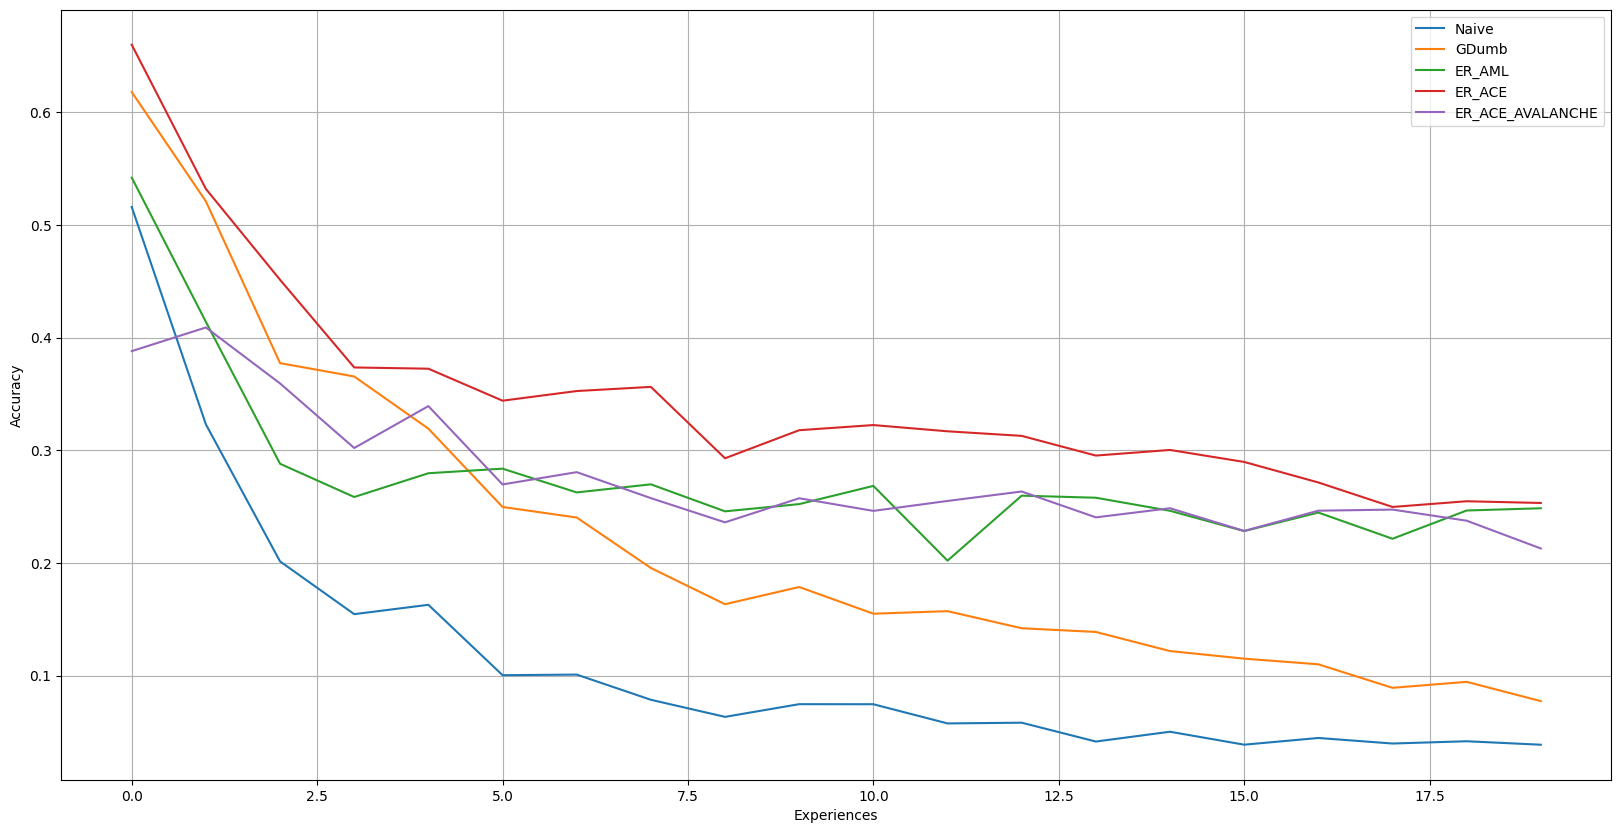

In [4]:
plot_over_experiences(
    {k: [sum(x.values()) / len(x.values()) for x in v['info']] for k, v in paper_test_results.items()},
    xlabel='Experiences',
    ylabel='Accuracy'
)

Plot of strategies forgetting.

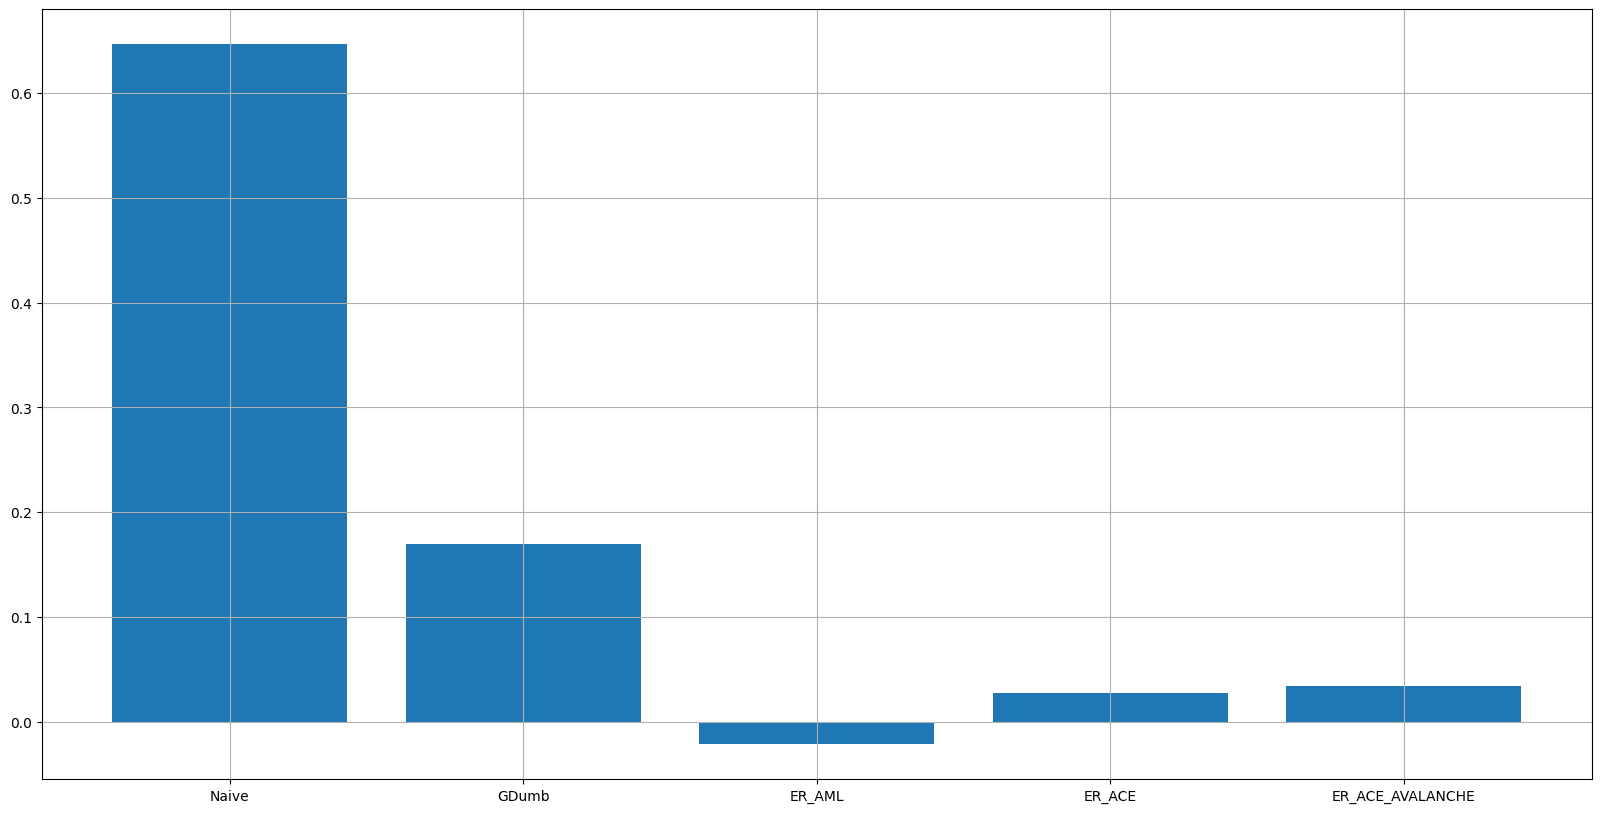

In [5]:
plot_forgetting(paper_test_results)

Plot of first experience accuracy over new experiences learning.

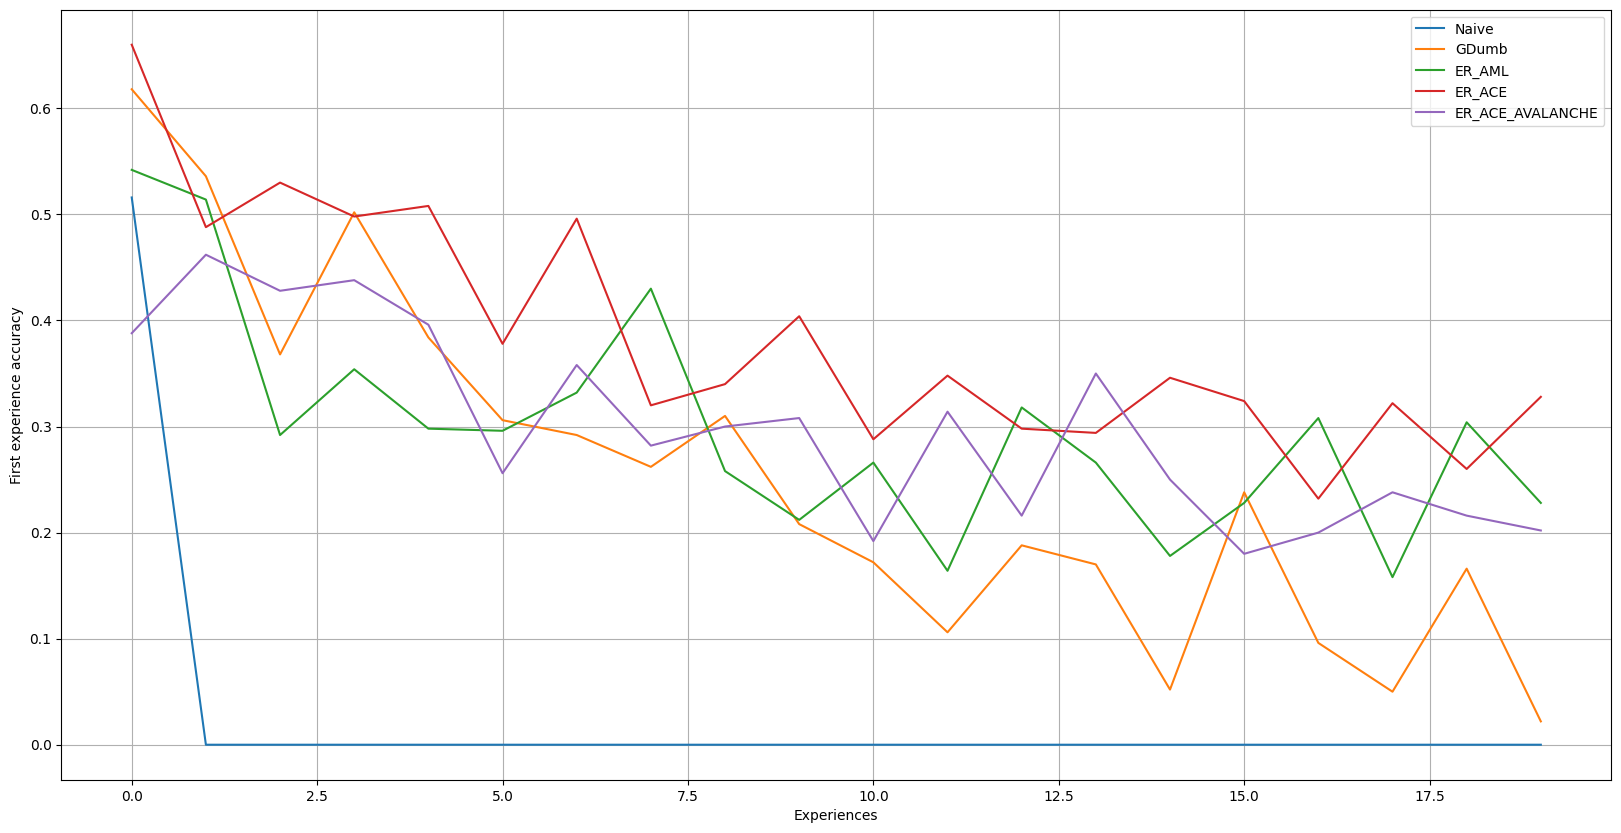

In [6]:
plot_over_experiences(
     {
         k: [x['Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000']
             for x in v['info']]
         for k, v in paper_test_results.items()
     },
    xlabel='Experiences',
    ylabel='First experience accuracy'
)

Accuracy table of experiences over time for each strategy.

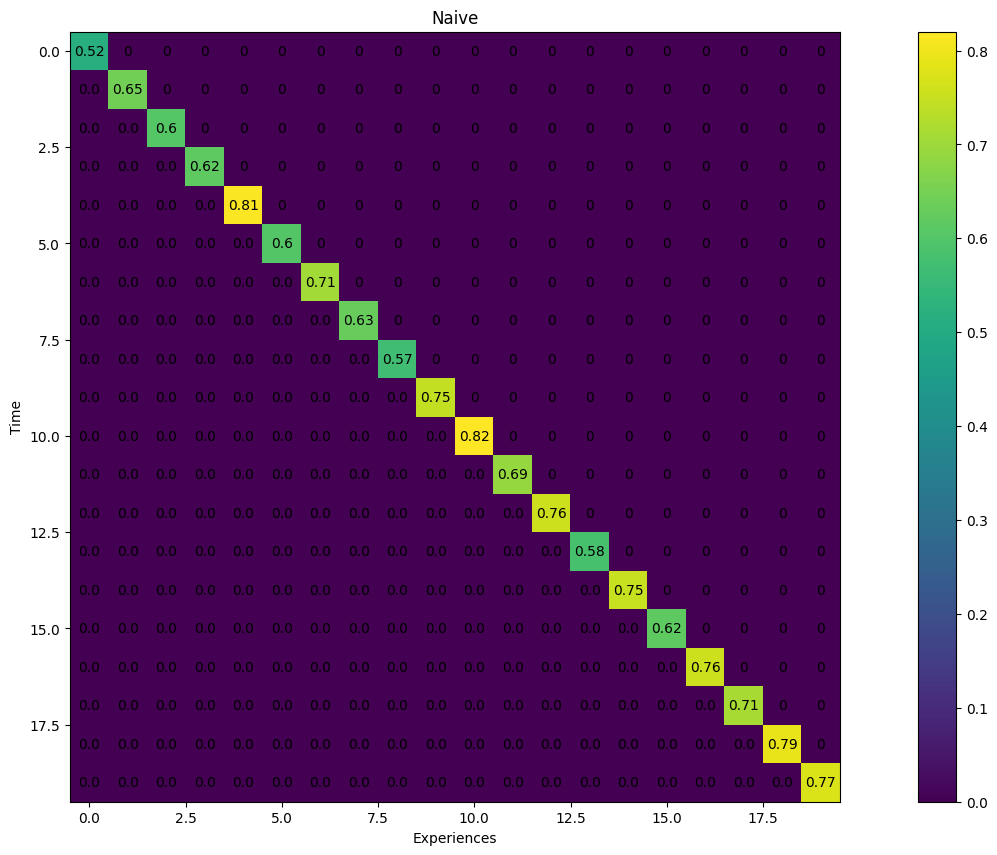

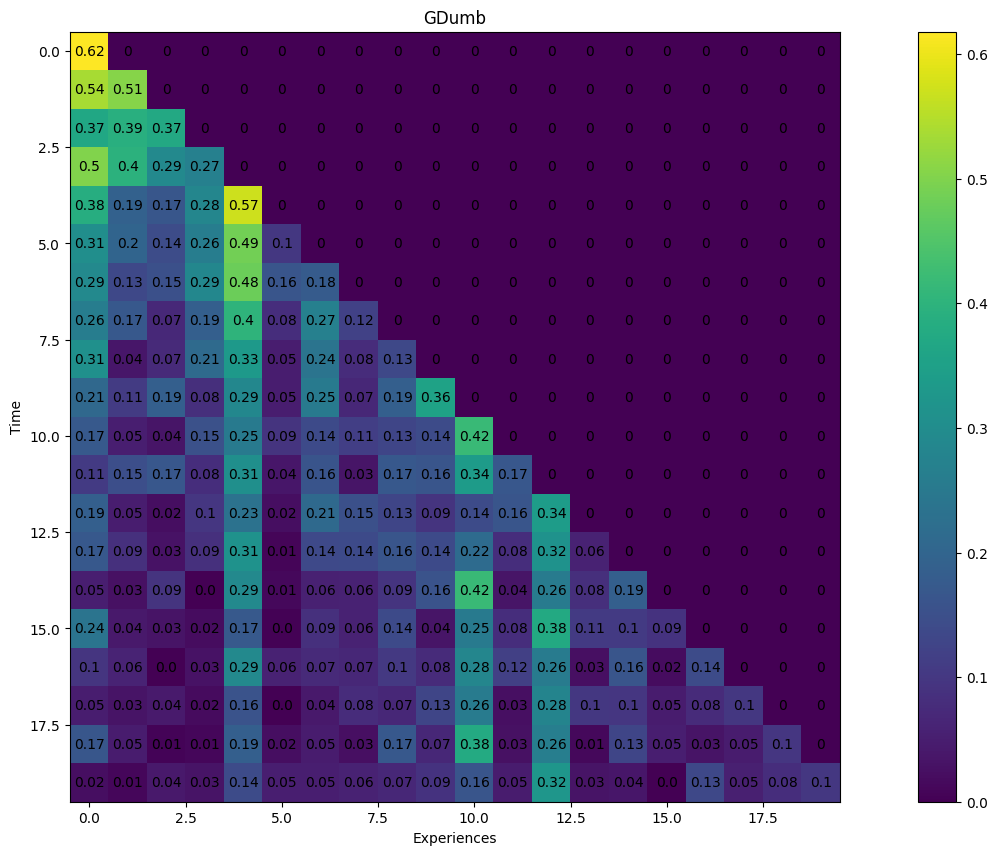

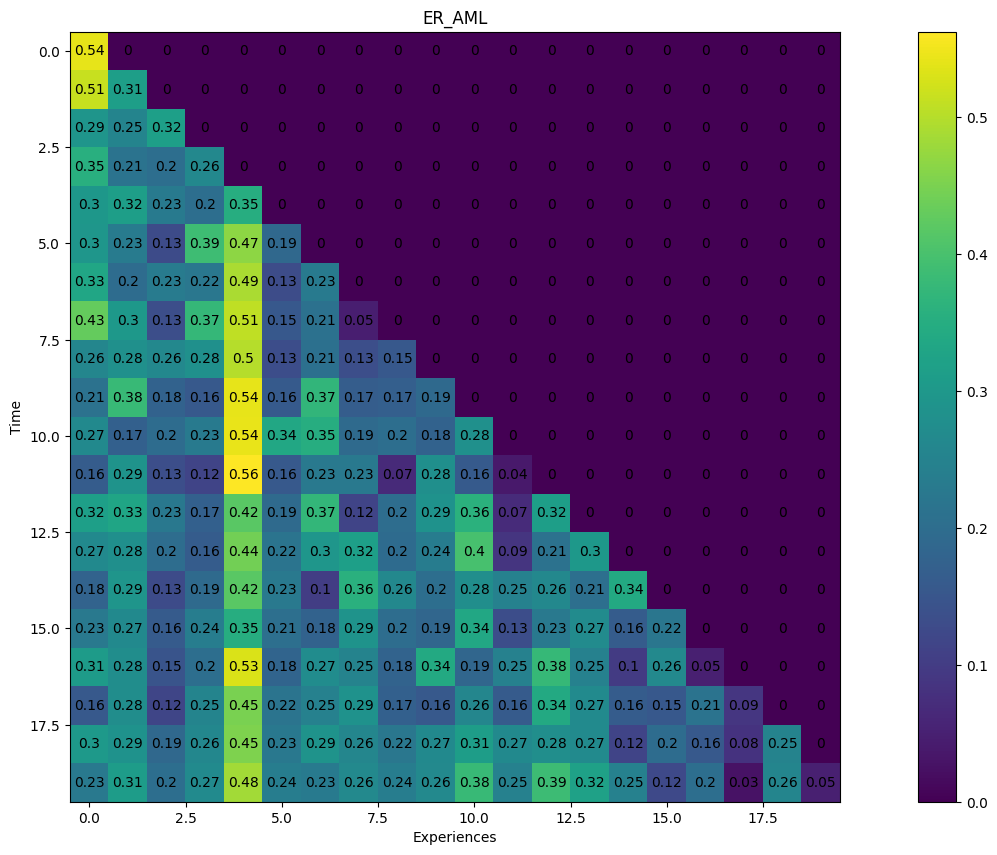

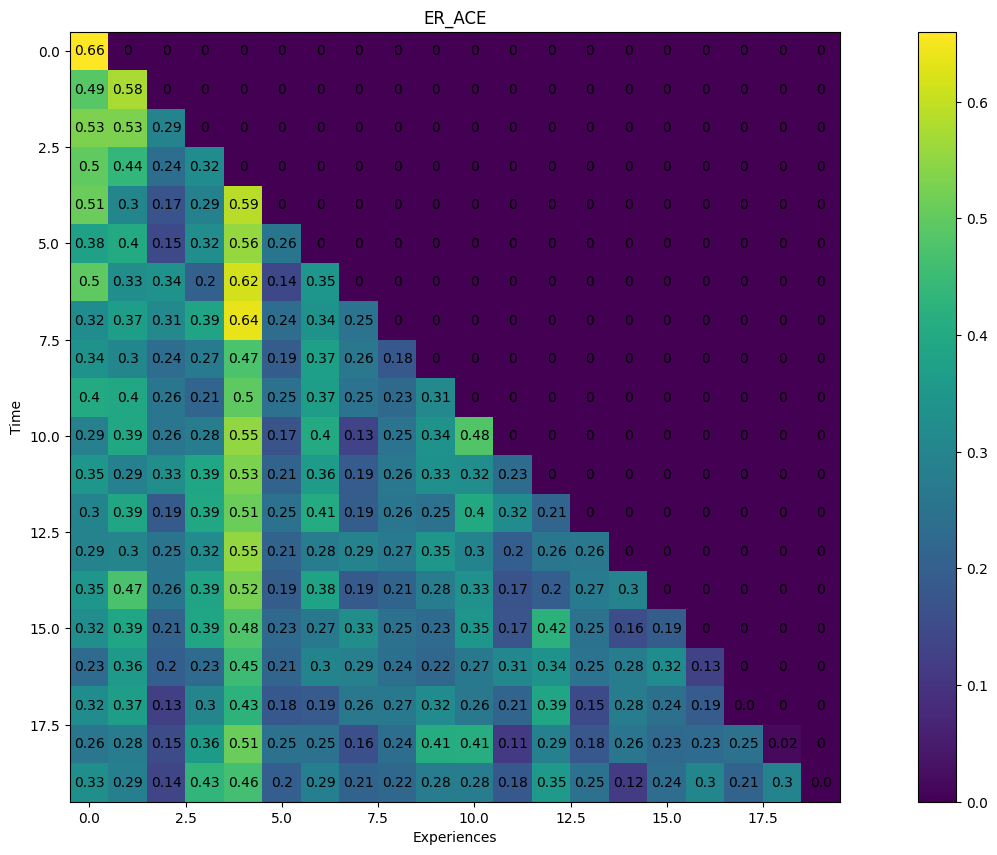

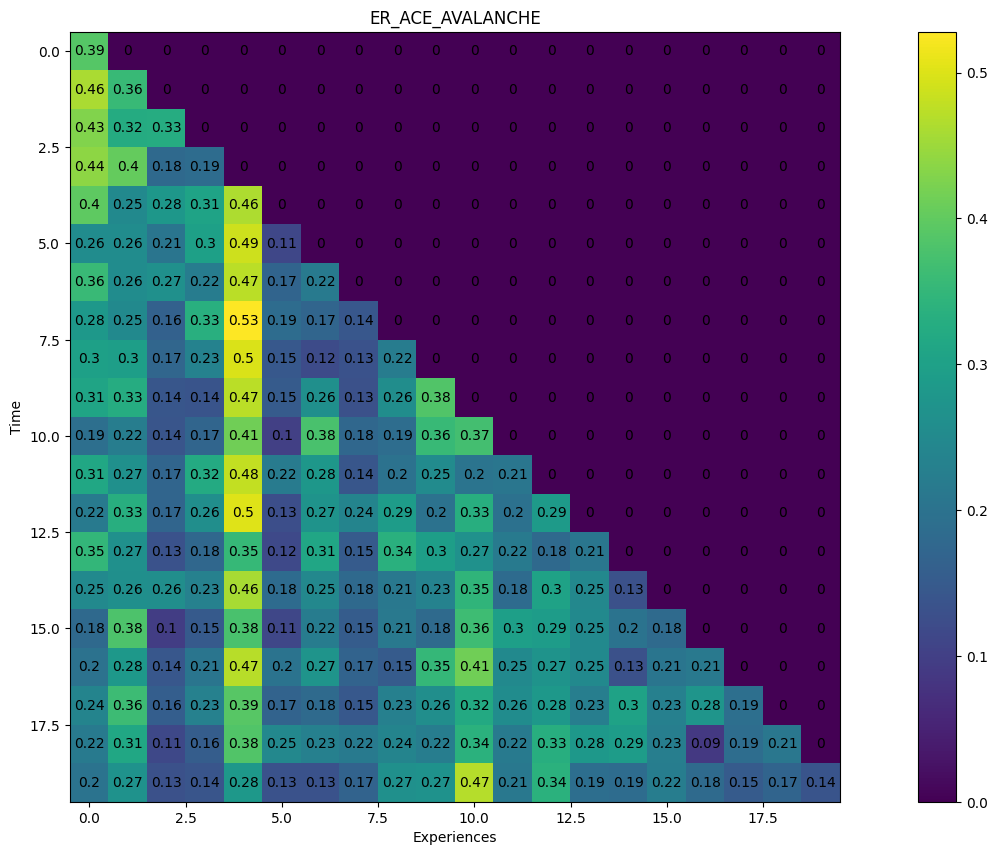

In [7]:
plot_accuracy_tables(paper_test_results)

### 4. Conclusion
Making a comparison with the original paper ER_AML is slightly worse in performance according AAA and accuracy while ER_ACE is better. Both the techniques (ER_AML more than ER_ACE) after 3 experiences starts to converge to a stable accuracy performance.

# N-Iters results

In [8]:
with open('niters_results.json') as file:
    niters_results = json.load(file)

In [9]:
plot_general_results(niters_results)

,ER_AML [niters=1],ER_AML [niters=2],ER_AML [niters=4],ER_ACE [niters=1],ER_ACE [niters=2],ER_ACE [niters=4]
AAA,27.6 %,34.64 %,36.98 %,29.22 %,36.9 %,38.72 %
accuracy,24.85 %,27.66 %,24.89 %,22.95 %,28.69 %,26.22 %
strategy_train_mb_size,10,10,10,10,10,10
strategy_eval_mb_size,10,10,10,10,10,10
strategy_train_epochs,1,1,1,1,1,1
strategy_mem_size,10000,10000,10000,10000,10000,10000
strategy_batch_size_mem,10,10,10,10,10,10
strategy_temp,0.1,0.1,0.1,NaN,NaN,NaN
strategy_n_iters,1,2,4,1,2,4
sgd_lr,0.1,0.1,0.1,0.1,0.1,0.1


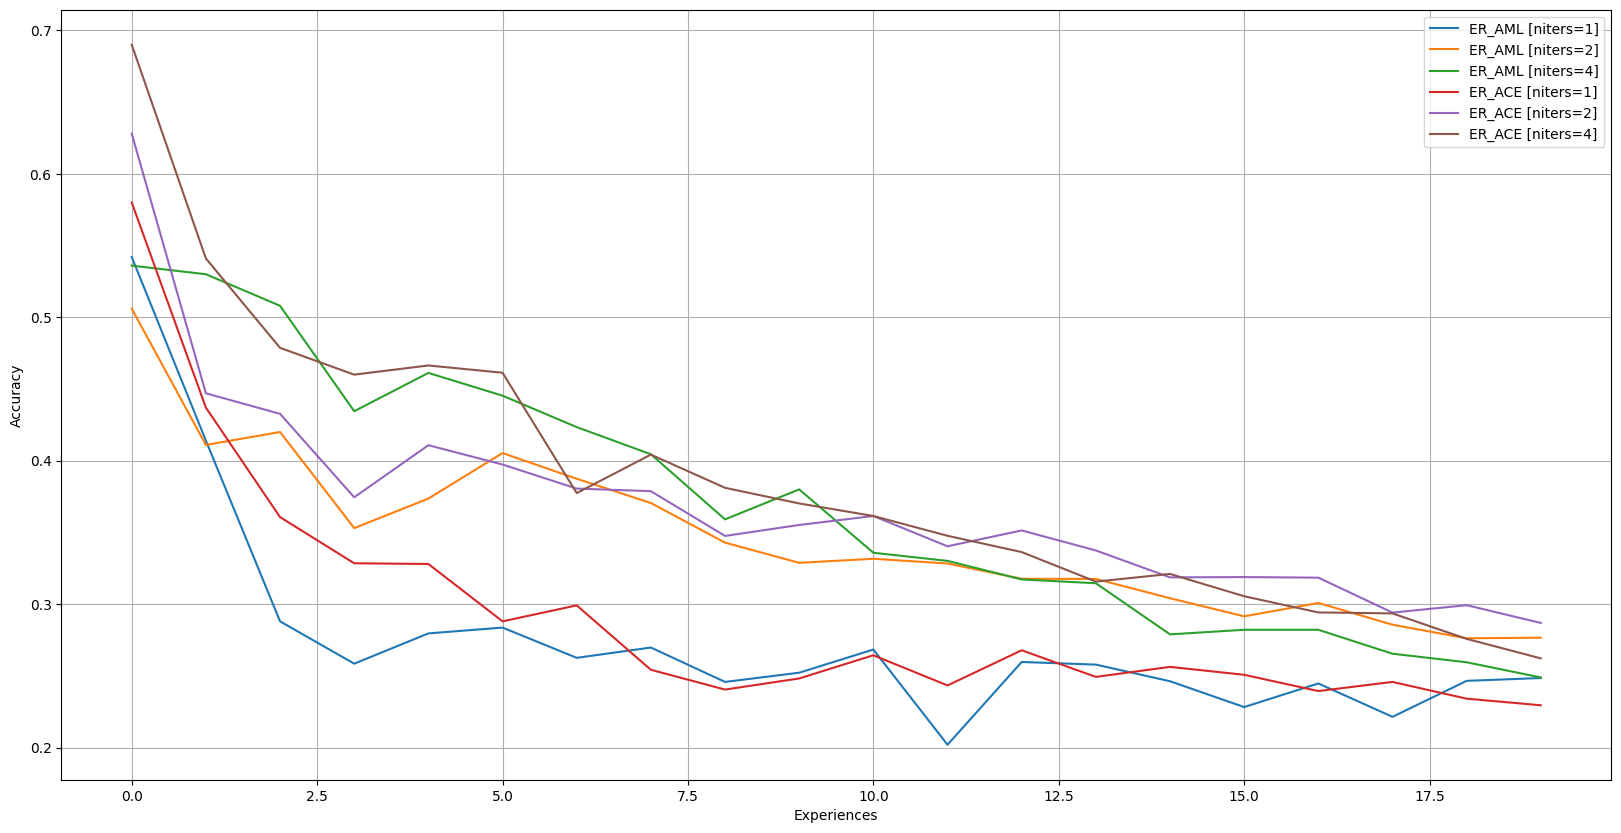

In [10]:
plot_over_experiences(
    {k: [sum(x.values()) / len(x.values()) for x in v['info']] for k, v in niters_results.items()},
    xlabel='Experiences',
    ylabel='Accuracy'
)

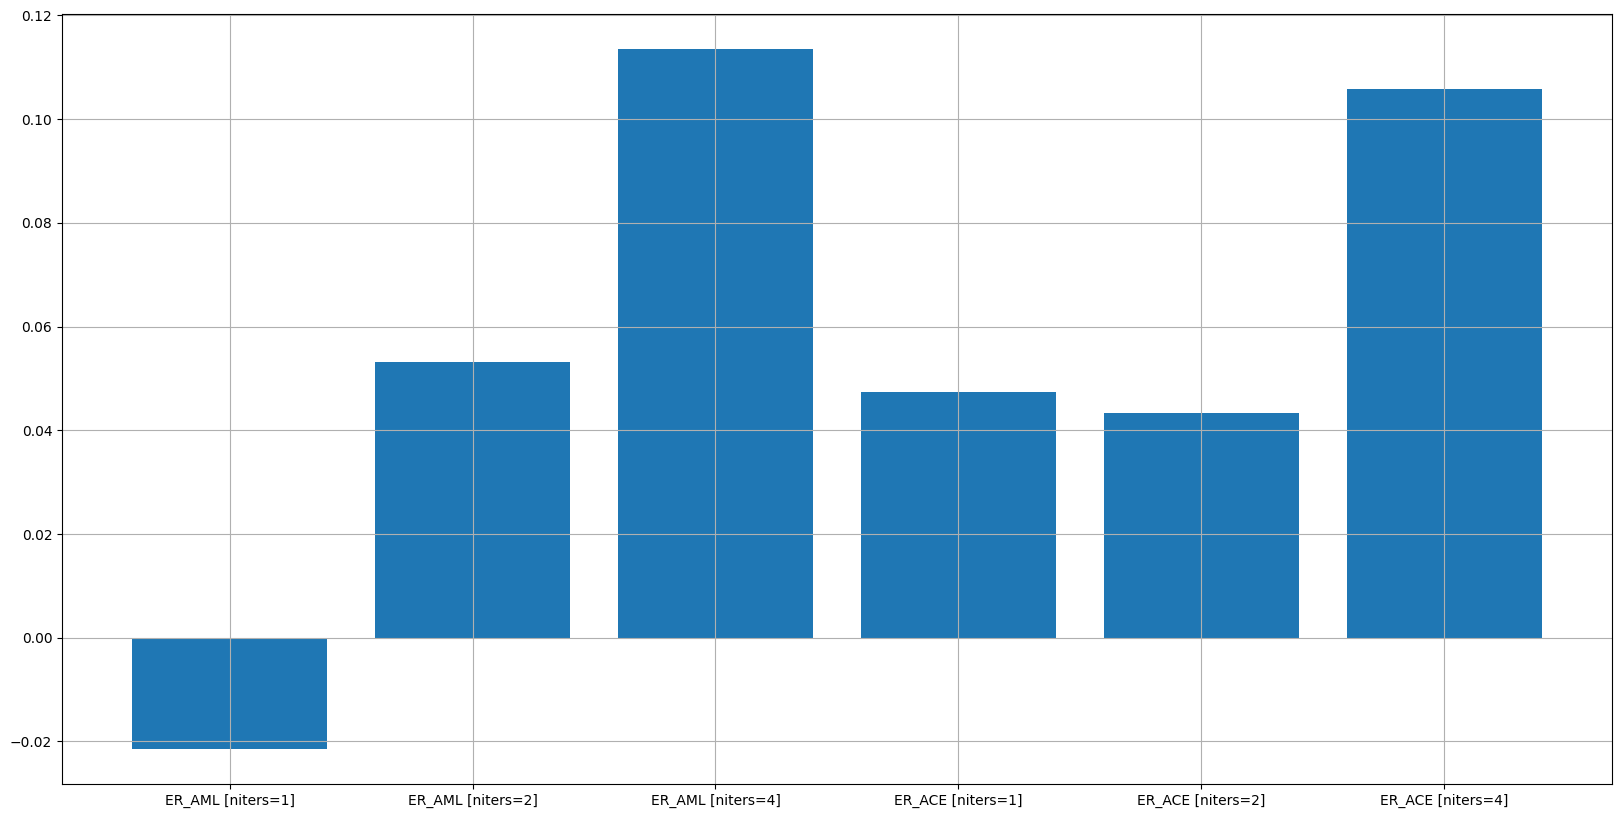

In [11]:
plot_forgetting(niters_results)

In [12]:
from src.model import ResNet18
import torch

{i: l for i, l in enumerate(ResNet18(20).modules()) if type(l) is torch.nn.BatchNorm2d}

{2: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 6: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 8: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 12: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 14: BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 19: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 21: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 24: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 27: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 29: BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 34: BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 36: BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True

In [13]:
bn_layers = ['12', '27', '42', '57']

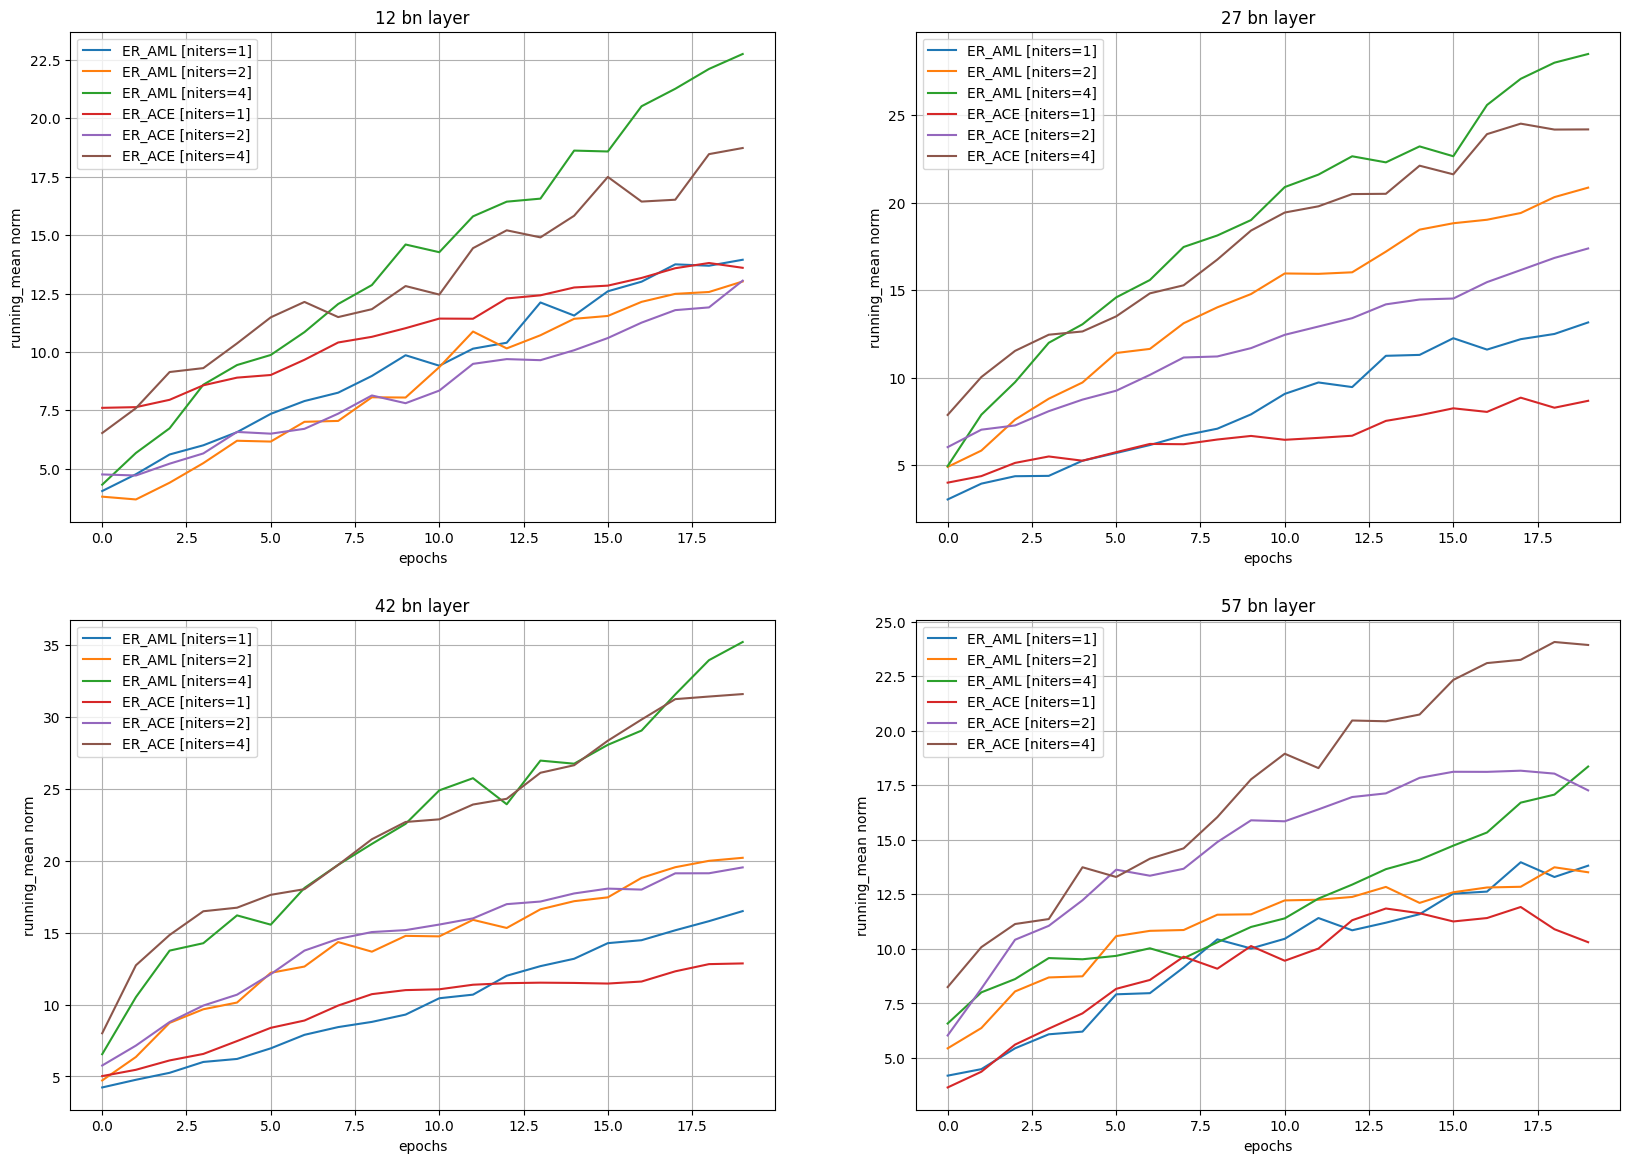

In [14]:
plot_bn_over_epochs(niters_results, layers=bn_layers, bn_feature='running_mean')

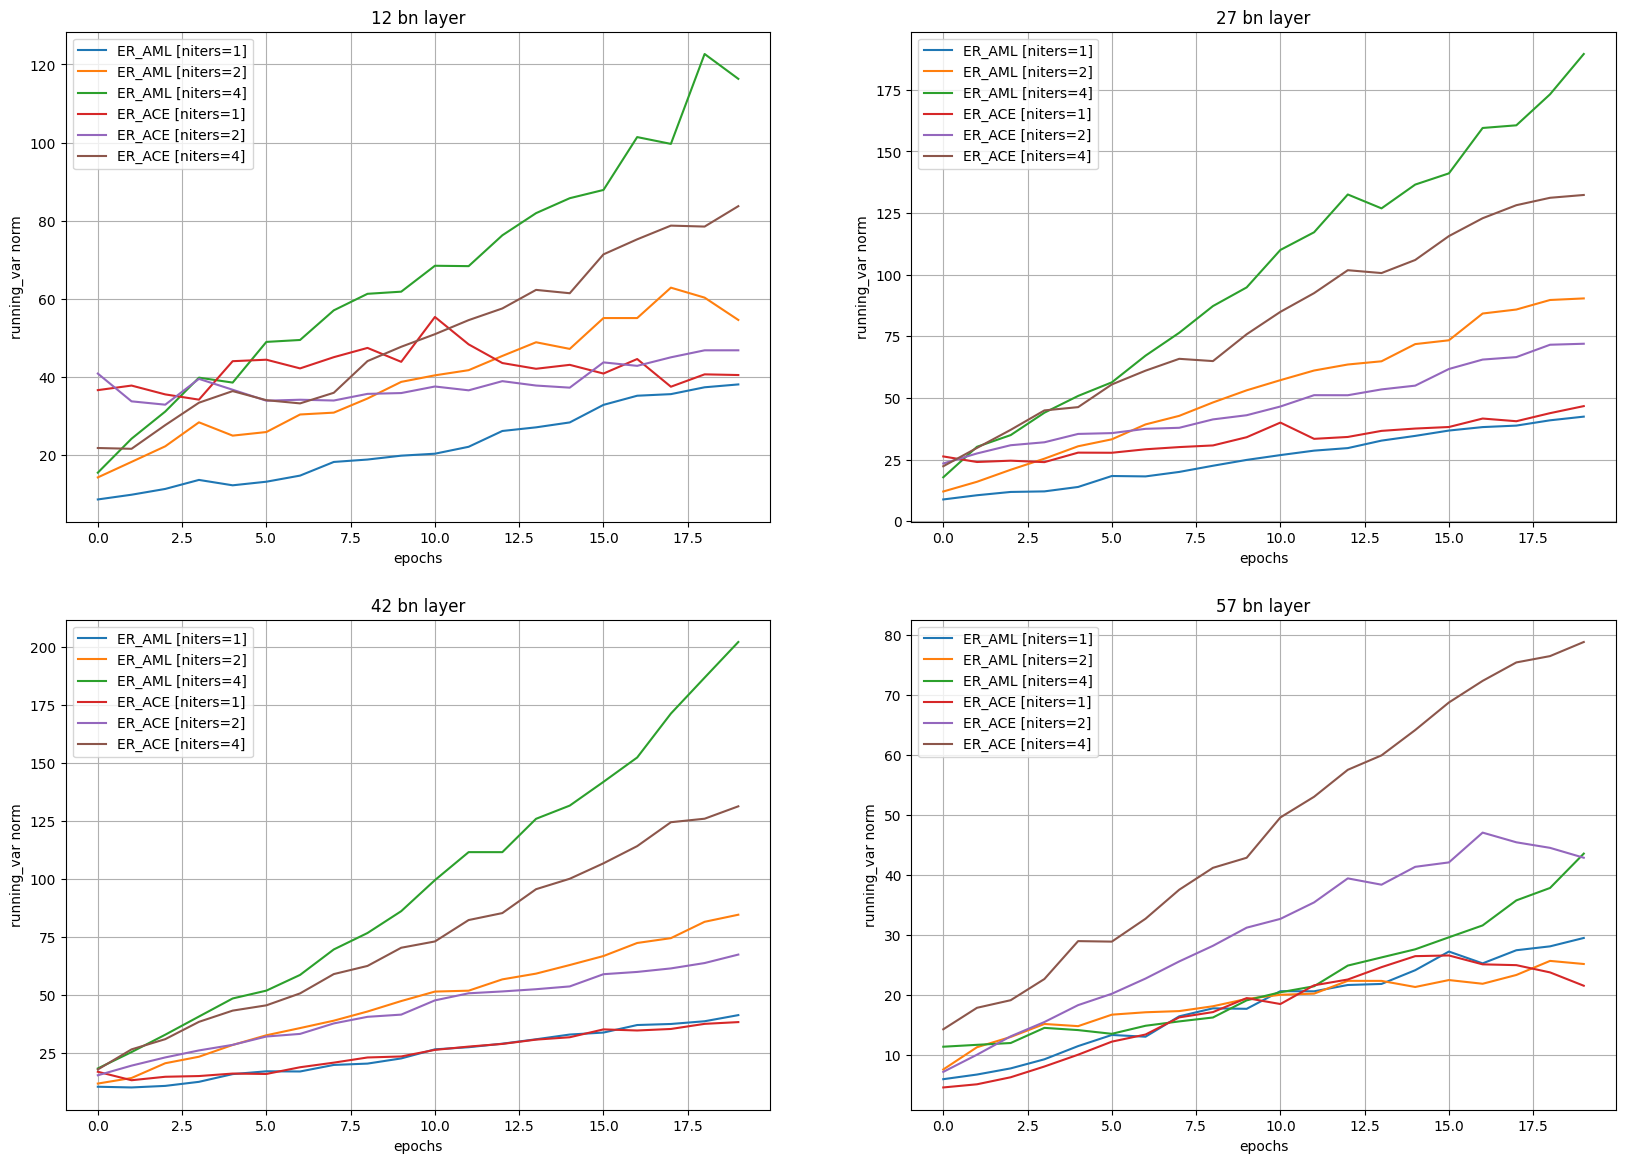

In [15]:
plot_bn_over_epochs(niters_results, layers=bn_layers, bn_feature='running_var')

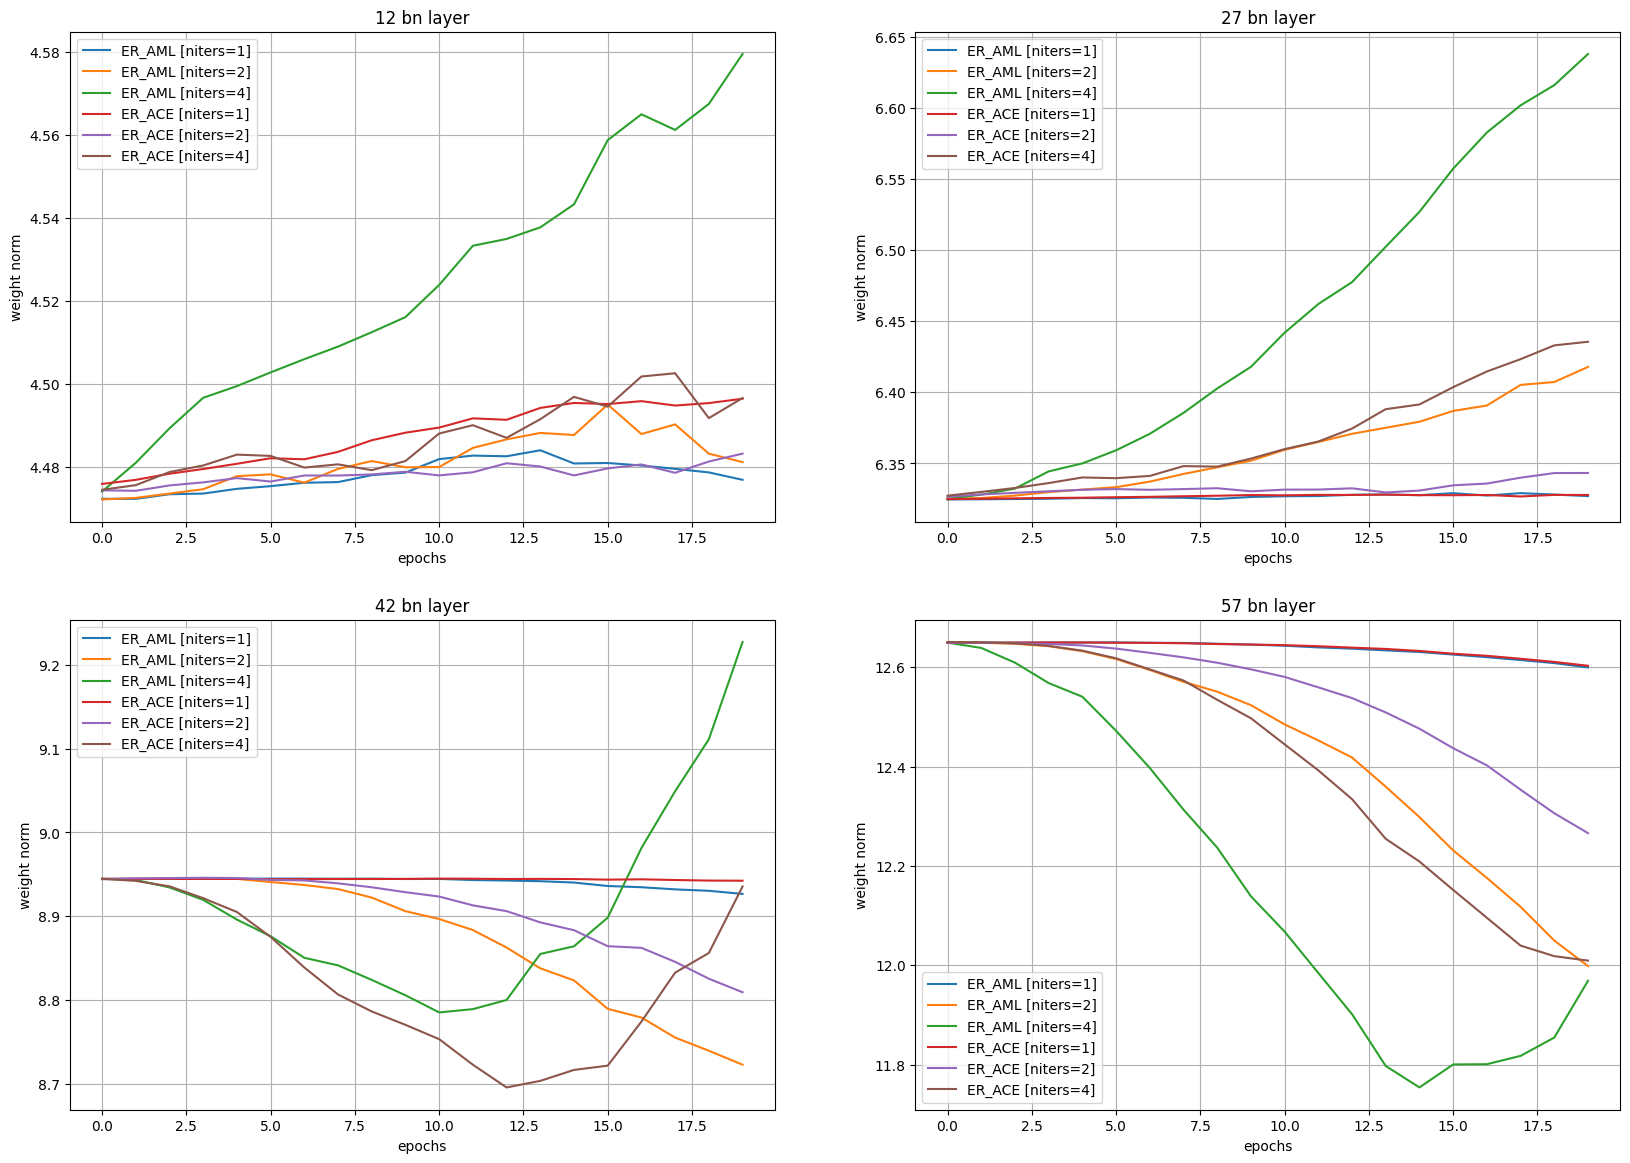

In [16]:
plot_bn_over_epochs(niters_results, layers=bn_layers, bn_feature='weight')

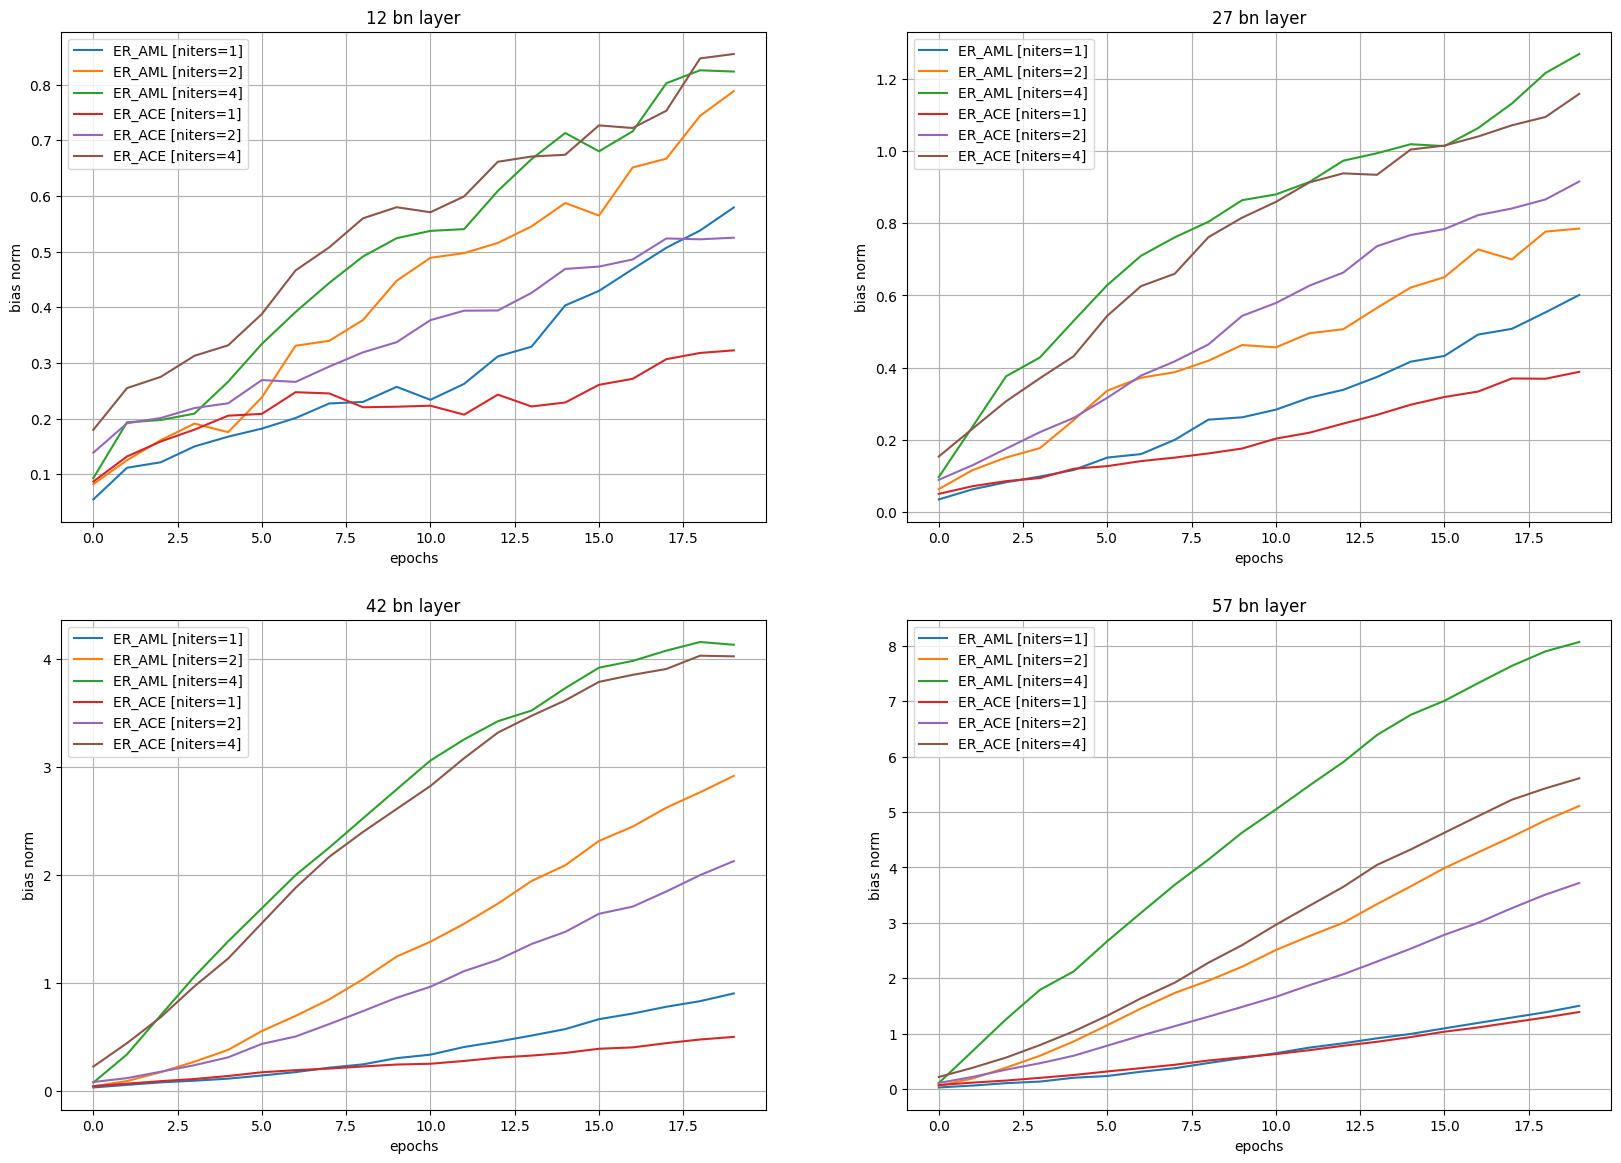

In [17]:
plot_bn_over_epochs(niters_results, layers=bn_layers, bn_feature='bias')